In [18]:
import numpy as np 
import pandas as pd 

In [19]:
import optuna
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt 
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
def get_data_loaders(batch_size):
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]

    # Transforms

    train_transform = transforms.Compose([
        transforms.Resize((150, 150)),            
        transforms.RandomHorizontalFlip(),        
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((150, 150)),            
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    data_dir = "/kaggle/input/teeth-dataset/Teeth_Dataset/"
    train_dataset = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=train_transform)
    val_dataset = datasets.ImageFolder(os.path.join(data_dir, "Validation"), transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, train_dataset, test_transform

In [25]:
def inverse_normalize(img_tensor, mean=[0.5]*3, std=[0.5]*3):
    inv = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )
    return inv(img_tensor)


def visualize_augmented_vs_original(train_dataset, test_transform, n_images=6):
    raw_dataset = datasets.ImageFolder(train_dataset.root, transform=test_transform)
    raw_loader = DataLoader(raw_dataset, batch_size=n_images, shuffle=True)
    aug_loader = DataLoader(train_dataset, batch_size=n_images, shuffle=True)

    raw_imgs, _ = next(iter(raw_loader))
    aug_imgs, _ = next(iter(aug_loader))

    raw_imgs = torch.stack([inverse_normalize(img) for img in raw_imgs])
    aug_imgs = torch.stack([inverse_normalize(img) for img in aug_imgs])

    def show_grid(images, title):
        grid = torchvision.utils.make_grid(images, nrow=n_images)
        npimg = grid.numpy().transpose((1, 2, 0))
        plt.figure(figsize=(12, 3))
        plt.imshow(np.clip(npimg, 0, 1))
        plt.axis('off')
        plt.title(title)
        plt.show()

    show_grid(raw_imgs, "Original Images")
    show_grid(aug_imgs, "Augmented Images")

def plot_class_distribution(train_dataset):
    class_names = train_dataset.classes
    class_counts = [0] * len(class_names)
    for _, label in train_dataset.samples:
        class_counts[label] += 1

    df = pd.DataFrame({
        "Class": class_names,
        "Count": class_counts
    })

    plt.figure(figsize=(8, 4))
    sns.barplot(data=df, x="Class", y="Count")
    plt.title("Training Set Class Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

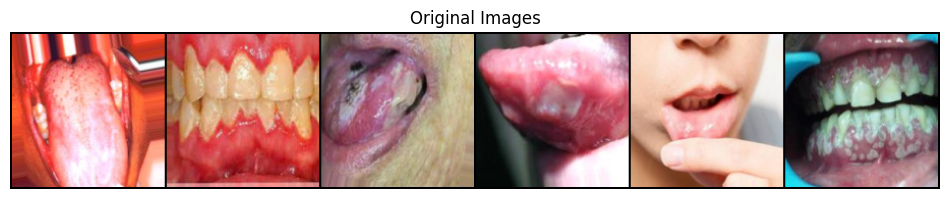

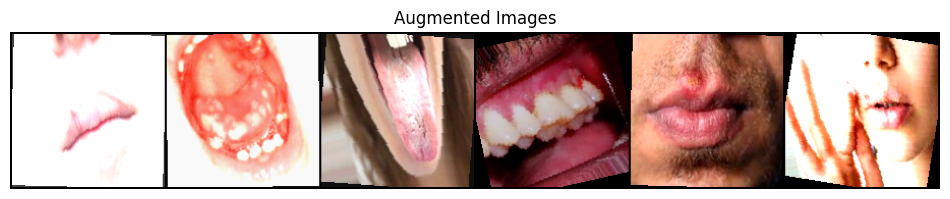

In [26]:
batch_size = 16
train_loader, val_loader, train_dataset, test_transform = get_data_loaders(batch_size)

visualize_augmented_vs_original(train_dataset, test_transform)

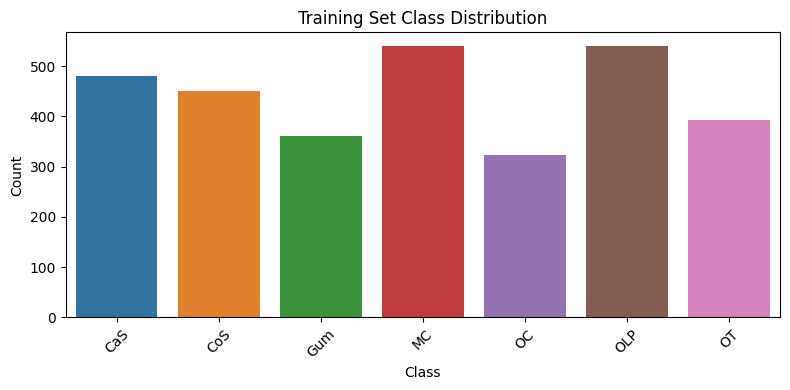

In [27]:
# Plot class counts
import seaborn as sns
plot_class_distribution(train_dataset)

In [28]:
def define_model(trial, num_classes):
    # Hyperparameter suggestions
    conv1_out = trial.suggest_int("conv1_out", 16, 64, step=16)
    conv2_out = trial.suggest_int("conv2_out", 32, 128, step=32)
    fc_size = trial.suggest_int("fc_size",64, 1028, step= 64)
    kernel_size = 3  # fixed based on earlier insight
    dropout_rate = trial.suggest_float("dropout", 0.3, 0.6)

    class TunedCNN(nn.Module):
        def __init__(self):
            super(TunedCNN, self).__init__()
            self.conv1 = nn.Conv2d(3, conv1_out, kernel_size=kernel_size, padding=1)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=kernel_size, padding=1)

            # Dynamically compute the flatten size
            with torch.no_grad():
                dummy_input = torch.zeros(1, 3, 224, 224)  # match input image size
                out = self.pool(F.relu(self.conv1(dummy_input)))
                out = self.pool(F.relu(self.conv2(out)))
                flatten_dim = out.view(1, -1).size(1)

            self.fc1 = nn.Linear(flatten_dim, fc_size)
            self.fc2 = nn.Linear(fc_size, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    return TunedCNN()

In [29]:
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    train_loader, val_loader, train_dataset, test_transform = get_data_loaders(batch_size)
    num_classes = len(train_dataset.classes)
    model = define_model(trial, num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    for epoch in range(5):  # just 3 epochs for speed
        for images, labels in tqdm(train_loader, leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)

# print("Best trial:")
# trial = study.best_trial
# print(f"  Accuracy: {trial.value}")
# print("  Params:")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

# class BestTeethCNN(nn.Module):
#     def __init__(self, num_classes, dropout=0.40636130138026194):
#         super(BestTeethCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(16, 128, kernel_size=3, padding=1)

#         # Compute flattened size
#         with torch.no_grad():
#             dummy = torch.zeros(1, 3, 224, 224)
#             out = self.pool(F.relu(self.conv1(dummy)))
#             out = self.pool(F.relu(self.conv2(out)))
#             self.flattened_size = out.view(1, -1).shape[1]

#         self.fc1 = nn.Linear(self.flattened_size, 256)
#         self.dropout = nn.Dropout(dropout)
#         self.fc2 = nn.Linear(256, num_classes)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         return self.fc2(x)



In [30]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Compute flattened size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 150, 150) 
            x = self.pool(F.relu(self.conv1(dummy)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [31]:
train_loader, val_loader, train_dataset, test_transform = get_data_loaders(16)
num_classes = len(train_dataset.classes)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {train_acc:.4f}")


Epoch [1/100], Loss: 356.3679, Accuracy: 0.2527
Epoch [2/100], Loss: 323.5079, Accuracy: 0.3382
Epoch [3/100], Loss: 293.4587, Accuracy: 0.4231
Epoch [4/100], Loss: 270.8632, Accuracy: 0.4772
Epoch [5/100], Loss: 252.6481, Accuracy: 0.5073
Epoch [6/100], Loss: 237.6358, Accuracy: 0.5413
Epoch [7/100], Loss: 225.4364, Accuracy: 0.5695
Epoch [8/100], Loss: 210.0538, Accuracy: 0.5990
Epoch [9/100], Loss: 201.5937, Accuracy: 0.6152
Epoch [10/100], Loss: 187.7358, Accuracy: 0.6437
Epoch [11/100], Loss: 181.8161, Accuracy: 0.6514
Epoch [12/100], Loss: 170.4904, Accuracy: 0.6825
Epoch [13/100], Loss: 160.2445, Accuracy: 0.6971
Epoch [14/100], Loss: 146.7621, Accuracy: 0.7266
Epoch [15/100], Loss: 141.9038, Accuracy: 0.7328
Epoch [16/100], Loss: 138.3341, Accuracy: 0.7464
Epoch [17/100], Loss: 123.6463, Accuracy: 0.7755
Epoch [18/100], Loss: 122.4367, Accuracy: 0.7775
Epoch [19/100], Loss: 117.7658, Accuracy: 0.7898
Epoch [20/100], Loss: 109.4194, Accuracy: 0.8014
Epoch [21/100], Loss: 102.501

In [33]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = correct / total
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Accuracy: 0.9397


In [34]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),            
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

data_dir = "/kaggle/input/teeth-dataset/Teeth_Dataset/"
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "Testing"), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [35]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = correct / total
print(f"test Accuracy: {val_acc:.4f}")


test Accuracy: 0.6247
